# Assignment-09
## < Multi-label classification using neural networks >
### -20154521 Seokjun Choi

In [0]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings#ignore warning messages
warnings.filterwarnings("ignore")

file_data   = "/content/drive/My Drive/mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines() #list[10,000]
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

num_training = 6000
num_testing = 4000

# normalize the values of the input data to be [0, 1]
def normalize(data):
    
    data_normalized = (data - min(data)) / (max(data) - min(data))
    
    return(data_normalized)

# make a matrix each column of which represents an images in a vector form
list_image    = np.empty((size_row * size_col, num_image), dtype=float)    #784*10,000
list_label    = np.empty(num_image, dtype=int) #list[10,000]

for line in data:

    line_data   = line.split(',') #list[1+784]
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:]) #list[784]
    im_vector   = normalize(im_vector)

    list_label[count]       = label
    list_image[:, count]    = im_vector

    count += 1
    
count = 0
label_vectors = np.empty((10, num_image), dtype=float)
#zero_vector = np.zeros(10, dtype=float)

for l in list_label:
    la_vector    = np.zeros(10, dtype=float)
    la_vector[l] = 1
    
    label_vectors[:, count] = la_vector
    count += 1
    
    
image_training = list_image[:, 0:num_training]         #784*6,000
image_testing  = list_image[:, num_training:num_image] #784*4,000

list_label_training = list_label[0:num_training]         #6,000
list_label_testing  = list_label[num_training:num_image] #4,000

label_training = label_vectors[:, 0:num_training]         #10*6,000
label_testing  = label_vectors[:, num_training:num_image] #10*4,000

bias_training = np.ones((1, num_training), dtype=int)
bias_testing  = np.ones((1, num_testing), dtype=int)

image_training = np.concatenate((bias_training, image_training), axis=0)#785*6,000
image_testing  = np.concatenate((bias_testing, image_testing), axis=0)#785*4,000

In [0]:
def sigmoid(matrix):
    return 1 / (1 + np.exp(-matrix))

def loss(h, label, m):
    return -(np.sum((label*np.log(h))+(1-label)*np.log(1-h)))/m

def forward_prop(u, v, w, x, m):
    bias = np.ones((1,m))
    
    y_ = u.dot(x)
    y  = sigmoid(y_)
    y  = np.concatenate((bias, y), axis=0)

    z_ = v.dot(y)
    z  = sigmoid(z_)
    z  = np.concatenate((bias, z), axis=0)
    
    h_ = w.dot(z)
    h  = sigmoid(h_)
    
    return y, z, h

In [0]:
def delta_4(h, label):
    return h-label

def delta_3(d4, w, z):
    diff1 = (w.T).dot(d4)
    diff2 = z * (1 - z)
    return diff1*diff2

def delta_2(d3, v, y):
    bias = np.ones((1, 197))
    v = np.concatenate((bias, v), axis=0)
    diff1 = (v.T).dot(d3)
    diff2 = y * (1 - y)
    return diff1*diff2

def partial_w(d4, z, m):
    return (d4.dot(z.T))/m
    
def partial_v(d3, y, m):
    return (d3.dot(y.T))/m

def partial_u(d2, x, m):
    return (d2.dot(x.T))/m

In [0]:
def predict(h, m): #return predicted label list
    
    pred_list = np.empty(m, dtype=int)
    for i in range(m):
        max = 0
        idx = 0
        for j in range(10):
            if max < h[j, i]:
                max = h[j, i]
                idx = j
        pred_list[i] = idx
        
    return pred_list

def getAccuracy(h, label, m): #return accuracy value
    
    correct = 0

    pred = predict(h, m)
    for i in range(m):
        if pred[i] == label[i]:
            correct += 1
    accuracy = correct / m
    
    return accuracy

In [0]:
#assign random values to weights(u, v, w)
u = np.empty((196, 785))
for i in range(785):
    u[:, i] = np.random.normal(0.0, 1, size = 196)/np.sqrt(785)
    
v = np.empty((49, 197))
for i in range(197):
    v[:, i] = np.random.normal(0.0, 1, size = 49)/np.sqrt(197)
    
w = np.empty((10, 50))
for i in range(50):
    w[:, i] = np.random.normal(0.0, 1, size = 10)/np.sqrt(50)
    
#set parameters
learning_rate = 1.85

t         = 0
iteration = list()

temp_loss = 0 
temp_loss_test = 0
train_loss_list = list()
test_loss_list  = list()

training_accuracy_list = list()
testing_accuracy_list = list()

In [0]:
while True:
    #back propagation
    
    #make training loss list
    (y, z, h) = forward_prop(u, v, w, image_training, num_training)
    if t>1 and abs(temp_loss - loss(h, label_training, num_training)) <= 0.00001:
        break
    temp_loss = loss(h, label_training, num_training)
    train_loss_list.append(temp_loss)
    iteration.append(t)

    #make testing loss list
    (y_test, z_test, h_test) = forward_prop(u, v, w, image_testing, num_testing)
    temp_loss_test = loss(h_test, label_testing, num_testing)
    test_loss_list.append(temp_loss_test)
    
    d4 = delta_4(h, label_training)
    d3 = delta_3(d4, w, z)
    d2 = delta_2(d3, v, y)
    
    p_w = partial_w(d4, z, num_training)
    temp_p_v = partial_v(d3, y, num_training)
    temp_p_u = partial_u(d2, image_training, num_training)
    
    p_v = temp_p_v[1:50, :]
    p_u = temp_p_u[1:197, :]
        
    w = w - learning_rate * p_w
    v = v - learning_rate * p_v
    u = u - learning_rate * p_u
    
    #make accuracy list
    training_accuracy = getAccuracy(h, list_label_training, num_training) * 100
    training_accuracy_list.append(training_accuracy)
    
    testing_accuracy = getAccuracy(h_test, list_label_testing, num_testing) * 100
    testing_accuracy_list.append(testing_accuracy)
    
    print(t, temp_loss, '\n')
    t += 1

0 7.265686094158244 

1 9.802981095320703 

2 4.019975876789295 

3 3.3133274457991337 

4 3.2643559253192986 

5 3.2577647652597927 

6 3.253943082530764 

7 3.2517647002173513 

8 3.25056664467176 

9 3.2497496531850683 

10 3.24928278254913 

11 3.2489481543427154 

12 3.248728774422142 

13 3.2485722450715206 

14 3.248445258784474 

15 3.2483548061292082 

16 3.248263276402152 

17 3.248195658802315 

18 3.2481163307310945 

19 3.2480536829551214 

20 3.247975817530325 

21 3.2479097242574153 

22 3.247827301554541 

23 3.247752683134132 

24 3.2476612110447354 

25 3.2475737865991943 

26 3.2474687983670223 

27 3.247363856984541 

28 3.2472400361511022 

29 3.247111680183959 

30 3.2469622304713557 

31 3.246802830190968 

32 3.2466190375002144 

33 3.2464189546670696 

34 3.2461901405197957 

35 3.24593802202168 

36 3.245652252116455 

37 3.245336204085398 

38 3.244981817501704 

39 3.2445910123407216 

40 3.2441577638920798 

41 3.2436824229532437 

42 3.243159661253693 

43

- The loss function $J(\theta)$.
  - $J(\theta)$ = $\frac{-1}{m}\sum_{i=1}^{m}(l^{(i)}log(\sigma(h^{(i)}))$ + $(1 - l^{(i)})log(1 -\sigma(h^{(i)})))$.

- Weights  $\theta = (u, v, w)$.

- Input data $x$.

- Predicted label $h$.

- $h = \sigma(w\sigma(v \sigma(u x))$.

- '$\sigma(z)$' is sigmoid for activation function.
  - $\sigma(z) = \frac{1}{1+e^{(-z)}}$.

- Back-propagation using partial derivatives.
  - $\delta^{(l)} = (\theta^{(l)})^{T}.a^{'}$
  - $\frac{\partial}{\partial\theta^{(l)}}J(\theta) = \delta^{(l+1)}(a^{(l)})^{T}$.
  - $\theta^{(l)}_{(t+1)}$ := $\theta^{(l)}_{(t)}$ - $\alpha\frac{\partial}{\partial\theta^{(l)}}J(\theta)$.

1. Plotting the loss curve
    - Load data from 'mnist.csv' file.
    - Make data sets for each digits.
    - Define functions for forward-propagation & back-propagation.
    - Oprimization u, v, w by gradient descent algorithm.
    - Plot the training & testing loss at every iteration of gradient descent

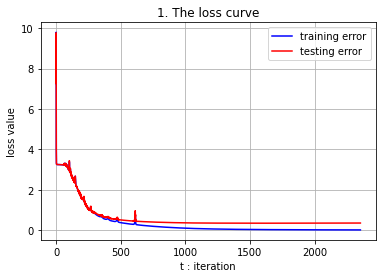

In [0]:
plt.plot(iteration, train_loss_list, c = 'blue')
plt.plot(iteration, test_loss_list, c = 'red')
plt.legend(['training error', 'testing error'])
plt.xlabel('t : iteration')
plt.ylabel('loss value')
plt.title('1. The loss curve')
plt.grid()
plt.show()

2. Plotting the accuracy curve
    - Get all training & testing accuracy(%) at every iteration by using defined function.

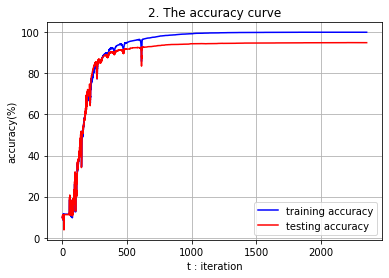

In [0]:
plt.plot(iteration, training_accuracy_list, c = 'blue')
plt.plot(iteration, testing_accuracy_list, c = 'red')
plt.legend(['training accuracy', 'testing accuracy'])
plt.xlabel('t : iteration')
plt.ylabel('accuracy(%)')
plt.title('2. The accuracy curve')
plt.grid()
plt.show()

3. Print the accuracy value
    - Print the final training & testing accuracy values.

In [0]:
print('3. The accuracy value')
print('The final training accuracy : ', training_accuracy, '%')
print('The final testing accuracy : ', testing_accuracy, '%')

3. The accuracy value
The final training accuracy :  100.0 %
The final testing accuracy :  94.925 %


4. Plotting the classification examples
    - Plot 10 correctly classified testing images.
    - Plot 10 misclassified testing images.

4. Plot the classification example

4 - 1. The correctly classified images


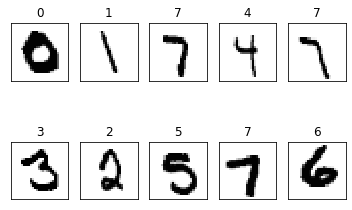

4 - 2. The misclassified images


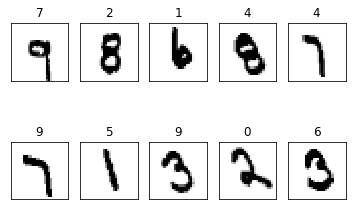

In [0]:
correct_images    = np.empty((size_row * size_col, 10), dtype=float)    #784*10
correct_labels    = np.empty(10, dtype=int)

incorrect_images  = np.empty((size_row * size_col, 10), dtype=float)    #784*10
incorrect_labels    = np.empty(10, dtype=int)

predict_list = predict(h, num_training)

correct_count = 0
incorrect_count = 0

print('4. Plot the classification example')
print()

#make groups of classified images
for i in range(num_testing):
    if predict_list[i] == list_label_testing[i] and correct_count < 10:
        correct_images[:, correct_count] = image_testing[1:, i]
        correct_labels[correct_count] = predict_list[i]
        correct_count += 1
    elif predict_list[i] != list_label_testing[i] and incorrect_count < 10:
        incorrect_images[:, incorrect_count] = image_testing[1:, i]
        incorrect_labels[incorrect_count] = predict_list[i]
        incorrect_count += 1
    elif incorrect_count >= 10 and correct_count >= 10:
        break
        

print('4 - 1. The correctly classified images')

for i in range(correct_count):

    plt.subplot(2, 5, i+1)
    plt.title(correct_labels[i])
    plt.imshow(correct_images[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.show()
    
print('4 - 2. The misclassified images')

for i in range(incorrect_count):

    plt.subplot(2, 5, i+1)
    plt.title(incorrect_labels[i])
    plt.imshow(incorrect_images[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.show()
